## Likelihood-free estimation of stop model parameters

This notebook shows how to use approximate Bayesian computation via sequential Monte Carlo (ABC-SMC) using the pyABC package.

In [26]:
# imports

import pyabc
import json
from pprint import pprint
from pyabc import (ABCSMC,
                   RV, Distribution)
import numpy as np
import scipy.stats as st
import os
import pandas as pd
import matplotlib.pyplot as plt
from ssd import fixedSSD
from stoptaskstudy import StopTaskStudy

from pyABC import stopsignal_model, cleanup_metrics
%matplotlib inline

# specify study label to load results
study = 'inperson'
model = 'basic'

In [27]:
# load history from db file
history = pyabc.History(f'sqlite:///results/{study}_{model}_adaptive_distance.db')
assert history.id is not None
print(history.id)

1


In [28]:
with open(f'data/data_{study}.json') as f:
    observed_data = json.load(f)

observed_presp = pd.read_csv(f'data/presp_by_ssd_{study}.txt',  delimiter=r"\s+", index_col=0)

for i, value in enumerate(observed_presp.presp.values):
    observed_data[f'presp_{i}'] = value



In [29]:
plot_kde = False
if plot_kde:
    fig, ax = plt.subplots()
    for t in range(history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            xmin=0, xmax=1,
            x="mu_go", ax=ax,
            label="PDF t={}".format(t))
    #ax.axvline(observed_presp.presp.values, color="k", linestyle="dashed");
    ax.legend();


### Plot credible intervals on parameters across populations

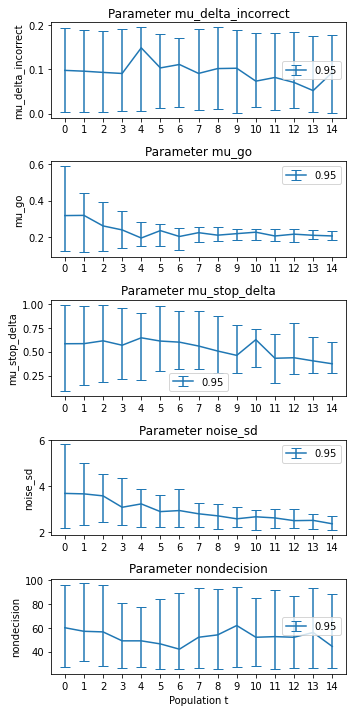

In [30]:

plot_ci = True
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,10))
if plot_ci:
    ci_ax = pyabc.visualization.plot_credible_intervals(history, arr_ax=axes)
    def get_map_estimates(ci_ax):
        map_estimates = {}
        for ax in ci_ax:
            map_estimates[ax.get_ylabel()] = ax.get_lines()[0].get_ydata()[-1]
        return(map_estimates)
    map_estimates = get_map_estimates(ci_ax)


### Show observed results vs simulation

In [31]:
print('MAP estimates for model parameters:')
pprint(map_estimates)

simulation = stopsignal_model(map_estimates)

results_df = pd.DataFrame(columns=['simulation', 'data'])

for k in simulation:
     if not k.find('presp')>-1:
         # print(k, simulation[k], observed_data[k])
         results_df.loc[k] = [simulation[k], observed_data[k]]
print()
print('Simulated vs observed results:')
print(results_df)



MAP estimates for model parameters:
{'mu_delta_incorrect': 0.09267470149435589,
 'mu_go': 0.20573975873768688,
 'mu_stop_delta': 0.3732849199988721,
 'noise_sd': 2.344781063101272,
 'nondecision': 44.32108329387925}

Simulated vs observed results:
                  simulation     data
mean_go_RT        443.589514  455.367
mean_stopfail_RT  384.741877  219.364
go_acc              0.894330    0.935


### Plot observed vs simulated p_respond across SSD

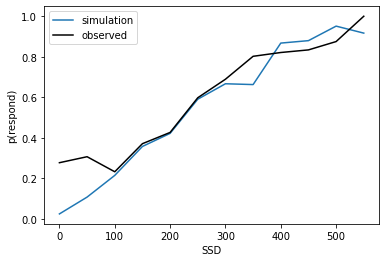

In [32]:

plot_presp = True
if plot_presp:
    simulation['presp'] = []
    for i in range(12):
        simulation['presp'].append(simulation[f'presp_{i}'])
    plt.plot(observed_presp.index, simulation['presp'])
    plt.plot(observed_presp.index, observed_presp.presp.values, 'k')
    plt.legend(['simulation', 'observed'])
    plt.xlabel('SSD')
    plt.ylabel('p(respond)')